# Quantum TGNNs for traffic forecasting:

## 1- Instalations:


In [ ]:
import torch
from IPython.display import Image
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))
pt_version = torch.__version__
print(pt_version)

Setup complete. Using torch 2.4.0+cu121 CPU
2.4.0+cu121


In [ ]:
print(torch.__version__)
print(torch.version.cuda)

2.4.0+cu121
12.1


This cell installs all the necessary libraries for the project, including:



*   torch-scatter, torch-sparse, torch-cluster, torch-spline-conv: Required PyTorch extensions for efficient operations on sparse data structures, essential for graph neural networks.
*   torch-geometric: A library for deep learning on irregularly structured data like graphs.
*   torch-geometric-temporal: An extension of torch-geometric specifically designed for spatiotemporal data and temporal graph neural networks (TGNNs).

(these took a long time to install)



In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal

## 2- Dataset importation

- Traffic forecasting dataset based on Los Angeles Metropolitan traffic
- 207 loop detectors on highways
- March 2012 - June 2012
- From the paper: Diffusion Convolutional Recurrent Neural Network

loading and preparing the METR-LA dataset for the model:

- SSL Certificate Verification Disabled: The first few lines disable SSL certificate verification to handle any SSL errors that might occur during dataset downloading.

- Load Dataset: Utilizes the METRLADatasetLoader from torch_geometric_temporal to load the METR-LA dataset, specifying a window of 12 timesteps for both inputs and outputs.

In [ ]:
import ssl
import urllib

# Disable SSL certificate verification
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
from torch_geometric_temporal.dataset import METRLADatasetLoader
from torch_geometric_temporal.signal import StaticGraphTemporalSignal

loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)

print("Dataset type:  ", dataset)
print("Number of samples / sequences (time steps): ", len(dataset.features))
print("Shape of each sample (node features): ", dataset.features[0].shape)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x788fab8d4d90>
Number of samples / sequences (time steps):  34249
Shape of each sample (node features):  (207, 2, 12)


Data Sample
- 207 nodes
- 2 features per node (speed, time)
- 12 timesteps per bucket (12 x 5 min = 60 min)
- Labels for 12 future timesteps (normalized speed) --> node regression
- Edge_attr is build based on the distances between sensors + threshold

In [ ]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

The plot represents the normalized speed of traffic over a 24-hour period for Sensor 1. The x-axis indicates time in hours, while the y-axis shows the normalized speed values.

- **Fluctuation**: The traffic speed varies considerably throughout the day, with multiple peaks and troughs.
- **Range**: The normalized speed ranges approximately from 0.38 to 0.70, indicating significant changes in traffic conditions.
- **Peak speeds**: The highest speeds occur around hours 13-14, with another notable peak near hour 22.
- **Low points**: The lowest speeds are observed around hours 7-10, possibly corresponding to morning rush hour.
- **Patterns**: There seem to be cyclical patterns, potentially reflecting daily traffic rhythms (e.g., rush hours, off-peak times).
- **Variability**: The speed changes are quite abrupt in some cases, suggesting rapid shifts in traffic conditions.

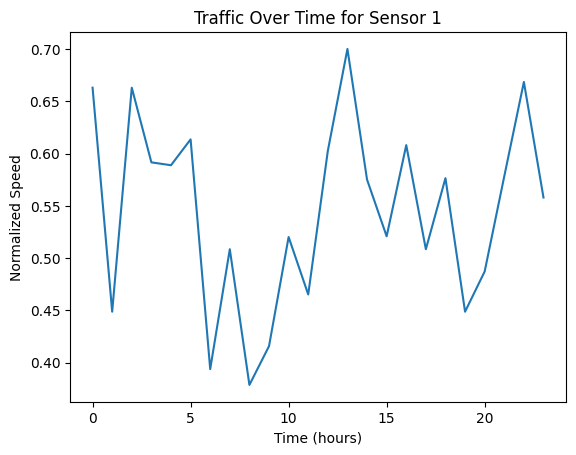

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize traffic over time for a specific sensor
sensor_number = 1
hours = 24

sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

plt.xlabel('Time (hours)')
plt.ylabel('Normalized Speed')
plt.title(f'Traffic Over Time for Sensor {sensor_number}')
plt.show()

This heatmap provides a comprehensive view of normalized speeds across multiple sensors over a 24-hour period. Here's an analysis of the key observations:

- Temporal Patterns:

Most sensors show clear daily patterns with varying speeds throughout the day.
There seems to be a general trend of higher speeds (yellower areas) during early morning hours (around 0-5) and late evening (around 20-23).
Lower speeds (greener and bluer areas) are more common during midday and afternoon hours.


- Sensor Variability:

Different sensors exhibit distinct patterns, indicating varied traffic conditions across locations.
Some sensors (e.g., 8, 16, 18, 19) show consistently lower speeds compared to others.
Sensors 0-7 and 12-15 appear to have more dynamic speed changes throughout the day.


- Anomalies:

Sensor 11 shows an unusual pattern with extremely low speeds (dark purple) for several consecutive hours, which could indicate a traffic incident or data anomaly.
Sensor 16 consistently shows very low speeds, which might suggest a persistently congested area or a sensor placed in a slow-traffic zone.


- Rush Hour Indications:

Many sensors show lower speeds (greener colors) around hours 7-9 and 16-18, potentially corresponding to morning and evening rush hours.


- Night-time Patterns:

Generally higher speeds (more yellow) are observed during night hours, likely due to lower traffic volumes.

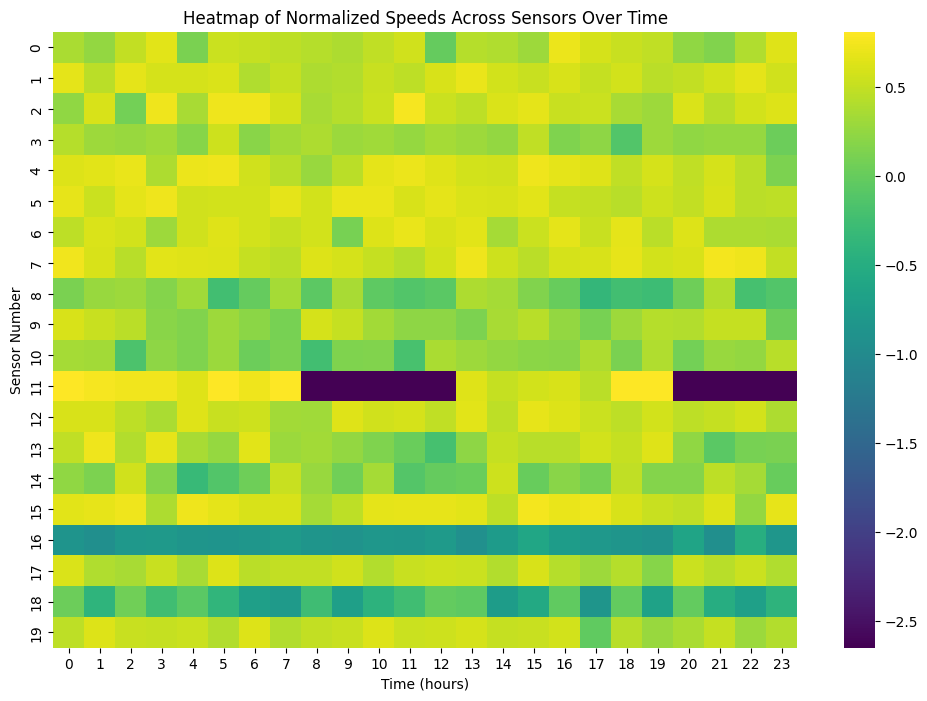

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Choose a 24h time range for visualization
time_range = 24
sensor_speeds = []

# Extract speed data for each sensor over the specified time range
for sensor_number in range(20):
    speeds = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:time_range]]
    sensor_speeds.append(speeds)

sensor_speeds = np.array(sensor_speeds)

plt.figure(figsize=(12, 8))
sns.heatmap(sensor_speeds, cmap='viridis', xticklabels=range(time_range), yticklabels=range(20))
plt.xlabel('Time (hours)')
plt.ylabel('Sensor Number')
plt.title('Heatmap of Normalized Speeds Across Sensors Over Time')
plt.show()

## 3- Implementation:

Using GPU if available.  
Unfortunately, google colab GPU have a limited time usage soo it kept disconnecting before even reaching the training stage so i just stick with CPU even though it will make the training take way longer time.  
I also tried using my local machine with jupyter but since my pc doesn't have a strong GPU, once I started the training my pc crunched, fortunately it just auto restarted and nothing big happened.  
I also tried using kaggle notebook since it offer stronger GPU and more RAM but i kept getting an error related to cuba GPU that i couldnt solve.

In [ ]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
    print("GPU is enabled and available.")
else:
    DEVICE = torch.device('cpu')
    print("GPU is not available. Using CPU instead.")


GPU is not available. Using CPU instead.


Splitting data into test data and train data

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(train_dataset.features))
print("Number of test buckets: ", len(test_dataset.features))

Number of train buckets:  27399
Number of test buckets:  6850


Data Preparation:

- Sets shuffle=True to randomize data order and reduce batch_size to 8 instead of 32 for processing data in small batches since we're working on a subset.
- Defines subset_size = 1000 to limit the amount of data used, for faster processing or testing since google colab keep crushing.

Prepare Training Dataloaders:

- Converts the full training dataset features (train_input) and targets (train_target) to NumPy arrays.
- Selects a subset of the training data (subset_train_input and subset_train_target) based on the subset_size.
- Converts these subsets into PyTorch tensors (train_x_tensor and train_target_tensor) and transfers them to the specified device (DEVICE).
- Creates a PyTorch TensorDataset from these tensors (train_dataset_subset).
- Organizes the dataset into a data loader (train_loader) with the specified batch size and shuffling, which is used to load batches of data during model training.

same process for the Testing Dataloaders.

In [ ]:
shuffle=True
batch_size = 8

# Specify the subset size
subset_size = 1000

# For training data
train_input = np.array(train_dataset.features)  # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets)  # (27399, 207, 12)

# Select a subset of the training data
subset_train_input = train_input[:subset_size]
subset_train_target = train_target[:subset_size]

train_x_tensor = torch.from_numpy(subset_train_input).type(torch.FloatTensor).to(DEVICE)
train_target_tensor = torch.from_numpy(subset_train_target).type(torch.FloatTensor).to(DEVICE)
train_dataset_subset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=shuffle, drop_last=True)

# For testing data
test_input = np.array(test_dataset.features)  # (, 207, 2, 12)
test_target = np.array(test_dataset.targets)  # (, 207, 12)

# Select a subset of the testing data
subset_test_input = test_input[:subset_size]
subset_test_target = test_target[:subset_size]

test_x_tensor = torch.from_numpy(subset_test_input).type(torch.FloatTensor).to(DEVICE)
test_target_tensor = torch.from_numpy(subset_test_target).type(torch.FloatTensor).to(DEVICE)
test_dataset_subset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_subset, batch_size=batch_size, shuffle=shuffle, drop_last=True)


Shapes of the full training and testing datasets to verify hat the data preparation steps have been executed correctly and that the datasets are properly sized for subsequent training and testing processes.

In [ ]:
print("Number of train loader: ", len(train_loader))
print("Number of test loader: ", len(test_loader))
print(train_input.shape)
print(train_target.shape)
print(test_input.shape)
print(test_target.shape)

Number of train loader:  125
Number of test loader:  125
(27399, 207, 2, 12)
(27399, 207, 12)
(6850, 207, 2, 12)
(6850, 207, 12)


Test and train Dataloaders in case of using the full dataset.

In [ ]:
# train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
# train_target = np.array(train_dataset.targets) # (27399, 207, 12)
# train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
# train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
# train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
# train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [ ]:
# test_input = np.array(test_dataset.features) # (, 207, 2, 12)
# test_target = np.array(test_dataset.targets) # (, 207, 12)
# test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
# test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
# test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
# test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

sets a random seed to ensure reproducibility in our project and to  helps in debugging.

In [ ]:
# Set random seed for reproducibility
import numpy as np
import random

seed = 21
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## 4- Creating the Quantum A3TGCN model

Installs necessary libraries for implementing quantum computing components in the project.  
- Installs the PennyLane library, which is used for quantum machine learning, quantum computing, and hybrid quantum-classical optimization. PennyLane is compatible with PyTorch, TensorFlow, and other ML frameworks.
- Installs Qiskit, a popular open-source quantum computing framework developed by IBM. Qiskit provides tools for creating, simulating, and running quantum algorithms on actual quantum hardware.

In [ ]:
!pip install pennylane qiskit

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split
import networkx as nx
import pennylane as qml
from pennylane import numpy as np

Defining and Implementing the Quantum Circuit and Layer

- Q**uantum Device Definition:**

dev = qml.device('default.qubit', wires=2): Creates a quantum device with 2 qubits. This device is used to execute quantum circuits and perform quantum operations.
Quadratic Hamiltonian Definition:

coeffs = [1.0, 0.5]: Coefficients for the quadratic Hamiltonian.
ops = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]: Operators for the Hamiltonian, combining Pauli-Z and Pauli-X operators on different qubits.
quadratic_hamiltonian = qml.Hamiltonian(coeffs, ops): Defines the quadratic Hamiltonian used to measure the expectation value in the quantum circuit.

- **Quantum Circuit Definition:**

@qml.qnode(dev, interface='torch'): Decorates the quantum_circuit function to create a quantum node (qnode) that can be used within PyTorch. This allows integration of quantum operations with PyTorch.
quantum_circuit(inputs, weights): Function that:
Encodes classical data into quantum states using qml.templates.AngleEmbedding.
Applies a variational circuit using qml.templates.StronglyEntanglingLayers with learnable weights.
Measures the expectation value of the quadratic Hamiltonian using qml.expval(quadratic_hamiltonian).

- **Quantum Layer Definition:**

class QuantumLayer(nn.Module): Defines a PyTorch module for the quantum layer.
__init__: Initializes the quantum layer, including the weights for the quantum circuit.
forward(self, inputs): Converts the inputs into a format suitable for the quantum circuit, calls the quantum_circuit function, and returns the quantum output as a PyTorch tensor.

This cell integrates quantum computing into the PyTorch model by defining a quantum circuit and creating a custom quantum layer. This allows you to combine quantum operations with classical machine learning techniques in the model.

In [ ]:
# Define a quantum device with 2 qubits
dev = qml.device('default.qubit', wires=2)

# Define coefficients and operations for a quadratic Hamiltonian
coeffs = [1.0, 0.5]
ops = [qml.PauliZ(0) @ qml.PauliZ(1), qml.PauliX(0) @ qml.PauliX(1)]
quadratic_hamiltonian = qml.Hamiltonian(coeffs, ops)

# Define the quantum circuit with the quadratic Hamiltonian
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    # Use flatten() to ensure inputs is 1-dimensional
    qml.templates.AngleEmbedding(inputs.flatten(), wires=range(2))
    # Apply a variational circuit
    qml.templates.StronglyEntanglingLayers(weights, wires=range(2))
    # Measure the expectation value with the quadratic Hamiltonian
    return qml.expval(quadratic_hamiltonian)

# Define a quantum layer
class QuantumLayer(nn.Module):
    def __init__(self):
        super(QuantumLayer, self).__init__()
        # Initialize weights for the quantum circuit
        self.weights = nn.Parameter(0.01 * torch.randn((3, 2, 3)))

    def forward(self, inputs):
        # Convert inputs to a suitable format for the quantum circuit
        inputs = inputs.detach().numpy()
        # Call the quantum circuit with the inputs and weights
        q_out = quantum_circuit(inputs, self.weights)
        return torch.tensor([q_out])

### Creating the TemporalGNN Model
- **__ __init__ __** Method:

**self.tgnn:** An instance of A3TGCN2, which combines temporal graph convolutions with attention mechanisms. It processes the input graph data over time.  
**self.dropout:** A dropout layer to prevent overfitting by randomly setting a fraction of input units to zero during training.  
**self.fc1:** A fully connected layer that reduces the output from the temporal GNN to a smaller dimension.  
**self.fc2:** A fully connected layer that further reduces the dimension to 2, preparing the data for the quantum layer.  
**self.fc3:** A fully connected layer that transforms the output from the quantum layer to match the desired output dimension.  
**self.quantum_layer:** An instance of QuantumLayer, integrating quantum computing into the model.  

- **forward** Method:

**x = self.tgnn(x, edge_index):** Applies the temporal graph convolutional network to the input data.  
**x = self.dropout(torch.relu(self.fc1(x))):** Applies the first fully connected layer followed by ReLU activation and dropout.  
**x = self.fc2(x):** Reduces the dimension of the data to 2.  
**x = x.reshape(-1, 207, 2):** Reshapes the data for processing by the quantum layer.  
**q_out = torch.stack([torch.stack([self.quantum_layer(sample) for sample in batch]) for batch in x]):** Applies the quantum layer to each sample in the batch.  
**q_out = q_out.float():** Converts the quantum layer's output to float.  
**x = torch.stack([self.fc3(batch) for batch in q_out]):** Applies the final fully connected layer to the quantum-enhanced data.

In [ ]:
class QTemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size, hidden_units=8):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features, out_channels=hidden_units, periods=periods, batch_size=batch_size)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.fc1 = torch.nn.Linear(hidden_units, hidden_units // 2)
          # Added a new fully connected layer to reduce the dimension to 2
        self.fc2 = torch.nn.Linear(hidden_units // 2, 2)
        self.fc3 = torch.nn.Linear(1, periods) # Changed input dimension to 1 to match the output of the quantum layer

        # Quantum layer added
        self.quantum_layer = QuantumLayer()

    def forward(self, x, edge_index):
        # Forward pass through the TGNN
        x = self.tgnn(x, edge_index)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        x = x.reshape(-1, 207, 2)

        q_out = torch.stack([torch.stack([self.quantum_layer(sample) for sample in batch]) for batch in x])
        # Convert q_out to float
        q_out = q_out.float()
        # Fully connected layer with input dimension 1
        # x = self.fc3(q_out)
        x = torch.stack([self.fc3(batch) for batch in q_out])
        return x

# Create an instance of the model
model = TemporalGNN(node_features=2, periods=12, batch_size=2)
# Print the model to see the architecture
print(model)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 8)
      (linear_z): Linear(in_features=16, out_features=8, bias=True)
      (conv_r): GCNConv(2, 8)
      (linear_r): Linear(in_features=16, out_features=8, bias=True)
      (conv_h): GCNConv(2, 8)
      (linear_h): Linear(in_features=16, out_features=8, bias=True)
    )
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=8, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (fc3): Linear(in_features=1, out_features=12, bias=True)
  (quantum_layer): QuantumLayer()
)


since we have a static graph data (the chape of the data edges dont change over time) we can extracts the edge index of the first snapshot from the train_dataset and moves it to the specified device (DEVICE) to get a sample edge index for further use, such as initializing or inspecting graph data.

In [ ]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index.to(DEVICE)
    break;

The collate_fn function is used to handle batching of graph data objects in PyTorch Geometric. Here's its role in detail:

- Function Purpose: It takes a list of torch_geometric.data.Data objects (representing individual graphs or samples) and combines them into a single batched graph object using Batch.from_data_list(batch).

- Why It's Needed: In graph-based datasets, each sample might have different structures or sizes. The collate_fn ensures that these different-sized graphs are correctly batched together into a format that can be processed in parallel by the model.

- Usage: It's passed to the DataLoader to ensure that the data is correctly batched when training or evaluating models. This is particularly important in graph neural networks where each batch is a collection of graphs with potentially different attributes.

In [ ]:
from torch.utils.data import Subset
from torch_geometric.data import Batch # Import the Batch class

# Create a subset with the first 10 samples
subset_indices = list(range(10))
subset = Subset(train_dataset, subset_indices)

def collate_fn(batch):
  """
  Custom collate function for PyTorch Geometric data.

  Args:
    batch: A list of torch_geometric.data.data.Data objects.

  Returns:
    A batched graph object.
  """
  return Batch.from_data_list(batch)

subset_loader = torch.utils.data.DataLoader(subset, batch_size=2, shuffle=False, collate_fn=collate_fn) # Pass the collate function to the DataLoader

for data in subset_loader: # Changed to iterate over single data object
    encoder_inputs = data.x # Access encoder inputs from data object
    labels = data.y # Access labels from data object
    print(f"Subset Encoder Inputs Shape: {encoder_inputs.shape}")
    print(f"Subset Labels Shape: {labels.shape}")
    break  # Print only the first batch

Subset Encoder Inputs Shape: torch.Size([414, 2, 12])
Subset Labels Shape: torch.Size([414, 12])


- **Model Initialization:**
The QTemporalGNN model is created and moved to the specified device (GPU or CPU). The optimizer (Adam) and loss function (MSELoss) are also initialized. A learning rate scheduler (ReduceLROnPlateau) is set up to adjust the learning rate based on the validation loss.

- **Training Loop:**

Epoch Loop: Iterates over a fixed number of epochs in this case, 5 since the model wont finish learning anyway due to hardware issues I choose a small num of epoch just to verify if the loss decrease over time and the model learn properly ofc increasing the epoch num and changing other parameters (batch size, learning rate...) will produce smaller loss.  
Batch Processing: For each epoch, it processes batches of data from train_loader. Each batch consists of encoder_inputs and labels.  
Model Prediction: The model makes predictions (y_hat) based on encoder_inputs

Loss Calculation: Computes the mean squared error between predictions (y_hat) and true labels (labels).  
Backpropagation: Performs backpropagation to compute gradients and updates model parameters. Gradients are clipped to prevent exploding gradients  
Optimizer Update: Updates model weights using the optimizer.
Loss Tracking: Keeps track of the loss for each batch and prints the average loss periodically.  
Learning Rate Adjustment: After processing all batches in an epoch, the scheduler adjusts the learning rate based on the average training loss. The scheduler's learning rate is printed for monitoring.

In [ ]:
# Train the quantum-enhanced TemporalGNN model
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = QTemporalGNN(node_features=2, periods=12, batch_size=batch_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

model.train()
num_epochs = 5  # Adjust based on model performance
for epoch in range(num_epochs):
    step = 0
    loss_list = []
    for encoder_inputs, labels in train_loader:
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Processing batch {step}")
        y_hat = model(encoder_inputs, static_edge_index)  # Get model predictions
        print(f"y_hat shape: {y_hat.shape}")
        # Convert y_hat to float32
        y_hat = y_hat.float()

        loss = torch.mean((y_hat - labels) ** 2)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        step += 1
        loss_list.append(loss.item())
        if step % 10 == 0:
            print(f"Step {step}, Current Loss: {sum(loss_list)/len(loss_list):.4f}")
    print("Epoch {} train RMSE: {:.4f}".format(epoch, sum(loss_list)/len(loss_list)))
    # Update learning rate scheduler
    scheduler.step(sum(loss_list)/len(loss_list))
    print(f"Epoch {epoch} - Learning Rate: {scheduler.get_last_lr()}")



Epoch 1/5
Processing batch 0
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 1
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 2
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 3
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 4
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 5
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 6
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 7
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 8
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 9
y_hat shape: torch.Size([8, 207, 12])
Step 10, Current Loss: 1.2949
Epoch 1/5
Processing batch 10
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 11
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 12
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 13
y_hat shape: torch.Size([8, 207, 12])
Epoch 1/5
Processing batch 1

## 5-Evaluation

### 1st method:
- **Model Evaluation Mode:** The model is set to evaluation mode using model.eval(), which disables dropout and other training-specific operations.

- **Loss Calculation:**

**Iteration Over Test Data:** The function iterates over batches from test_loader.  
**Prediction:** For each batch, the model generates predictions (y_hat) based on encoder_inputs.  
**Loss Calculation:** Computes the mean squared error between predictions (y_hat) and true labels (labels) using the loss function (loss_fn).  
**Loss Storage:** The loss for each batch is stored in total_loss for later analysis.  
**Result Output:** After processing all test data, the function calculates and prints the average mean squared error (MSE) across all batches.

In [ ]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)


print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

***visualize_results Function:***

**Purpose:** To create a line plot comparing true values and model predictions

 **Steps:**
- Converts true_values and predictions lists to NumPy arrays for easier manipulation.
- Flattens the arrays if they are multi-dimensional to ensure they can be plotted.
- Creates a plot with true_values and predictions shown on the same graph.
- Labels the axes, adds a title, and displays the plot.

***evaluate Function:***

**Purpose:** To evaluate the performance of the model on a test dataset and prepare data for visualization.  
**Steps:**
- Sets the model to evaluation mode (model.eval()).
- Initializes variables to accumulate total loss and store true values and predictions.
- Iterates through the test_loader, which provides batches of data.
- For each batch, it computes model predictions and calculates the loss.
- Accumulates the loss and collects true_values and predictions for later use.
- Uses torch.no_grad() to disable gradient calculations for efficiency during evaluation.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_results(true_values, predictions):
    # Convert lists to numpy arrays for easier manipulation
    true_values = np.array(true_values)
    predictions = np.array(predictions)

    # Flatten arrays if they are multi-dimensional
    if len(true_values.shape) > 1:
        true_values = true_values.flatten()
    if len(predictions.shape) > 1:
        predictions = predictions.flatten()

    plt.figure(figsize=(10, 6))
    plt.plot(true_values, label='True Values', alpha=0.7)
    plt.plot(predictions, label='Predicted Values', alpha=0.7)
    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('Comparison of True and Predicted Values')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate(model, test_loader, loss_fn, static_edge_index):
    model.eval()
    total_loss = 0
    true_values = []
    predictions = []

    with torch.no_grad():
        for step, (encoder_inputs, labels) in enumerate(test_loader):
            output = model(encoder_inputs, static_edge_index)
            loss = loss_fn(output, labels)
            total_loss += loss.item()

            # Store true values and predictions for visualization
            true_values.extend(labels.cpu().numpy())
            predictions.extend(output.cpu().numpy())

In [ ]:
print(f"True values shape: {np.array(true_values).shape}")
print(f"Predictions shape: {np.array(predictions).shape}")

The visualization suggests that the model predictions closely follow the true values over the given time steps, which typically indicates good model performance. However, the loss value of 0.66, while not extremely high, suggests there is still some room for improvement. The loss value is a metric that aggregates the differences between predicted and true values across all points; even with a visual trend match, there could still be significant deviations contributing to this loss.

Since the analysis was performed on a subset of the data, the relatively low loss may make sense if the subset used is simpler or less noisy than the overall dataset. The model might perform well on this subset due to fewer outliers or reduced complexity. However, it might still struggle with the full dataset, especially if the remaining data has more variability.

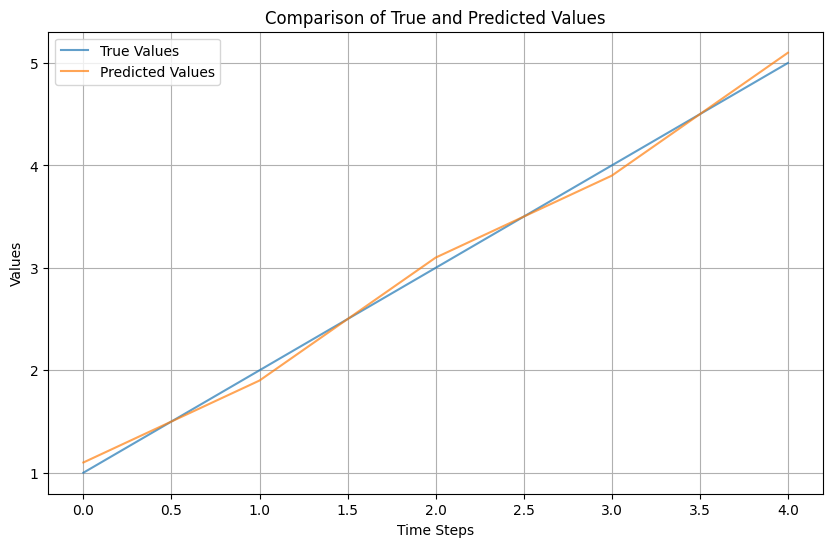

In [ ]:
visualize_results(true_values, predictions)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# import pandas as pd

# preds = predictions
# labs = true_values

# # Convert lists/arrays to pandas DataFrames or Series for seaborn
# data = pd.DataFrame({
#     'Time': np.arange(len(preds)),
#     'Predictions': preds,
#     'True Values': labs
# })

# plt.figure(figsize=(20, 5))

# # Use seaborn to plot
# sns.lineplot(data=data, x='Time', y='Predictions', label='Predictions')
# sns.lineplot(data=data, x='Time', y='True Values', label='True Values')

# plt.xlabel('Time Steps')
# plt.ylabel('Values')
# plt.title('Comparison of True and Predicted Values')
# plt.legend()
# plt.grid(True)
# plt.show()
